In [1]:
# 这个我们用Keras

In [2]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import copy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


In [3]:
# 看一下能不能上GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# 导入数据

label_dic = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

label = []

train_data = []

for i in label_dic.keys():
    for dirname, _, filenames in os.walk(r'.\train\%s' %label_dic[i]):
        for filename in filenames:
            try:
                image_array = Image.open(os.path.join(dirname, filename))
                image_array = image_array.resize((64,64),Image.ANTIALIAS)
                image_array = np.array(image_array)
                image_array = np.expand_dims(image_array, axis=2)
                train_data.append(image_array)
                label.append(i)
            except:
                pass


In [5]:
# 对数据进行标准化
train_data = np.array(train_data)
each_pixel_mean = train_data.mean(axis=0)
each_pixel_std = np.std(train_data, axis=0)
train_data = np.divide(np.subtract(train_data,each_pixel_mean), each_pixel_std)

In [6]:
# 把标签one hot
label= np.array(label).astype('str')
label = np.array(pd.get_dummies(pd.DataFrame(label),prefix='0').values.tolist())

In [7]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.3, shuffle = True, random_state = 255)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle = True, random_state = 255)

In [8]:
# 搭一个CNN
model = Sequential()

# 1-2层
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(64,64,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(64,64,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3-4层
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5-6层
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7-8层
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
# 全连接层
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label[0]), activation='softmax'))

In [9]:
# 查看一下
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        3

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 进行图像增强
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=False,
                             zoom_range = 0.05)
datagen.fit(X_train)

In [11]:
history = model.fit(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=300,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32)

pd.DataFrame(history.history).to_csv("history.csv")

Epoch 1/300
440/439 [==============================] - 13s 29ms/step - loss: 2.5994 - accuracy: 0.2180 - val_loss: 1.9328 - val_accuracy: 0.2523
Epoch 2/300
440/439 [==============================] - 12s 28ms/step - loss: 1.8360 - accuracy: 0.2423 - val_loss: 1.9661 - val_accuracy: 0.2466
Epoch 3/300
440/439 [==============================] - 12s 28ms/step - loss: 1.8232 - accuracy: 0.2497 - val_loss: 2.0956 - val_accuracy: 0.2385
Epoch 4/300
440/439 [==============================] - 12s 28ms/step - loss: 1.8196 - accuracy: 0.2481 - val_loss: 2.0961 - val_accuracy: 0.2556
Epoch 5/300
440/439 [==============================] - 12s 28ms/step - loss: 1.8094 - accuracy: 0.2501 - val_loss: 2.1876 - val_accuracy: 0.2523
Epoch 6/300
440/439 [==============================] - 12s 28ms/step - loss: 1.8087 - accuracy: 0.2515 - val_loss: 2.3642 - val_accuracy: 0.2531
Epoch 7/300
440/439 [==============================] - 12s 28ms/step - loss: 1.8052 - accuracy: 0.2524 - val_loss: 2.7774 - val_ac

440/439 [==============================] - 12s 27ms/step - loss: 1.2037 - accuracy: 0.5428 - val_loss: 1.1935 - val_accuracy: 0.5883
Epoch 112/300
440/439 [==============================] - 12s 27ms/step - loss: 1.2031 - accuracy: 0.5398 - val_loss: 1.1239 - val_accuracy: 0.5926
Epoch 113/300
440/439 [==============================] - 12s 27ms/step - loss: 1.2014 - accuracy: 0.5428 - val_loss: 1.1309 - val_accuracy: 0.5863
Epoch 114/300
440/439 [==============================] - 12s 27ms/step - loss: 1.1868 - accuracy: 0.5504 - val_loss: 1.1236 - val_accuracy: 0.5978
Epoch 115/300
440/439 [==============================] - 12s 27ms/step - loss: 1.1934 - accuracy: 0.5455 - val_loss: 1.1809 - val_accuracy: 0.5810
Epoch 116/300
440/439 [==============================] - 12s 27ms/step - loss: 1.1918 - accuracy: 0.5443 - val_loss: 1.1524 - val_accuracy: 0.5875
Epoch 117/300
440/439 [==============================] - 12s 27ms/step - loss: 1.1797 - accuracy: 0.5514 - val_loss: 1.1571 - val_ac

Epoch 167/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0903 - accuracy: 0.5884 - val_loss: 1.0881 - val_accuracy: 0.6099
Epoch 168/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0908 - accuracy: 0.5833 - val_loss: 1.0482 - val_accuracy: 0.6096
Epoch 169/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0797 - accuracy: 0.5891 - val_loss: 1.0476 - val_accuracy: 0.6205
Epoch 170/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0851 - accuracy: 0.5890 - val_loss: 1.0411 - val_accuracy: 0.6253
Epoch 171/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0796 - accuracy: 0.5907 - val_loss: 1.0595 - val_accuracy: 0.6170
Epoch 172/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0790 - accuracy: 0.5898 - val_loss: 1.0268 - val_accuracy: 0.6220
Epoch 173/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0839 - accuracy: 0.5880 - val_loss: 1

Epoch 223/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0198 - accuracy: 0.6219 - val_loss: 1.0323 - val_accuracy: 0.6358
Epoch 224/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0154 - accuracy: 0.6153 - val_loss: 1.0129 - val_accuracy: 0.6300
Epoch 225/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0151 - accuracy: 0.6192 - val_loss: 1.0657 - val_accuracy: 0.6306
Epoch 226/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0078 - accuracy: 0.6229 - val_loss: 1.0529 - val_accuracy: 0.6235
Epoch 227/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0161 - accuracy: 0.6154 - val_loss: 1.0626 - val_accuracy: 0.6296
Epoch 228/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0018 - accuracy: 0.6156 - val_loss: 1.0277 - val_accuracy: 0.6298
Epoch 229/300
440/439 [==============================] - 12s 28ms/step - loss: 1.0040 - accuracy: 0.6200 - val_loss: 1

Epoch 279/300
440/439 [==============================] - 12s 28ms/step - loss: 0.9543 - accuracy: 0.6372 - val_loss: 1.0640 - val_accuracy: 0.6195
Epoch 280/300
440/439 [==============================] - 12s 28ms/step - loss: 0.9536 - accuracy: 0.6379 - val_loss: 1.0553 - val_accuracy: 0.6358
Epoch 281/300
440/439 [==============================] - 12s 28ms/step - loss: 0.9585 - accuracy: 0.6350 - val_loss: 1.0318 - val_accuracy: 0.6369
Epoch 282/300
440/439 [==============================] - 12s 28ms/step - loss: 0.9528 - accuracy: 0.6395 - val_loss: 1.0770 - val_accuracy: 0.6331
Epoch 283/300
440/439 [==============================] - 12s 27ms/step - loss: 0.9490 - accuracy: 0.6399 - val_loss: 1.0757 - val_accuracy: 0.6343
Epoch 284/300
440/439 [==============================] - 12s 28ms/step - loss: 0.9565 - accuracy: 0.6399 - val_loss: 1.0352 - val_accuracy: 0.6401
Epoch 285/300
440/439 [==============================] - 12s 27ms/step - loss: 0.9492 - accuracy: 0.6402 - val_loss: 1

In [12]:
# 看一下test准确率
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Loss: " + str(scores[0]))
print("准确率: " + str(scores[1]))

9/9 [==============================] - 2s 223ms/step - loss: 1.1165 - accuracy: 0.6184
Loss: 1.1164623498916626
准确率: 0.618367612361908


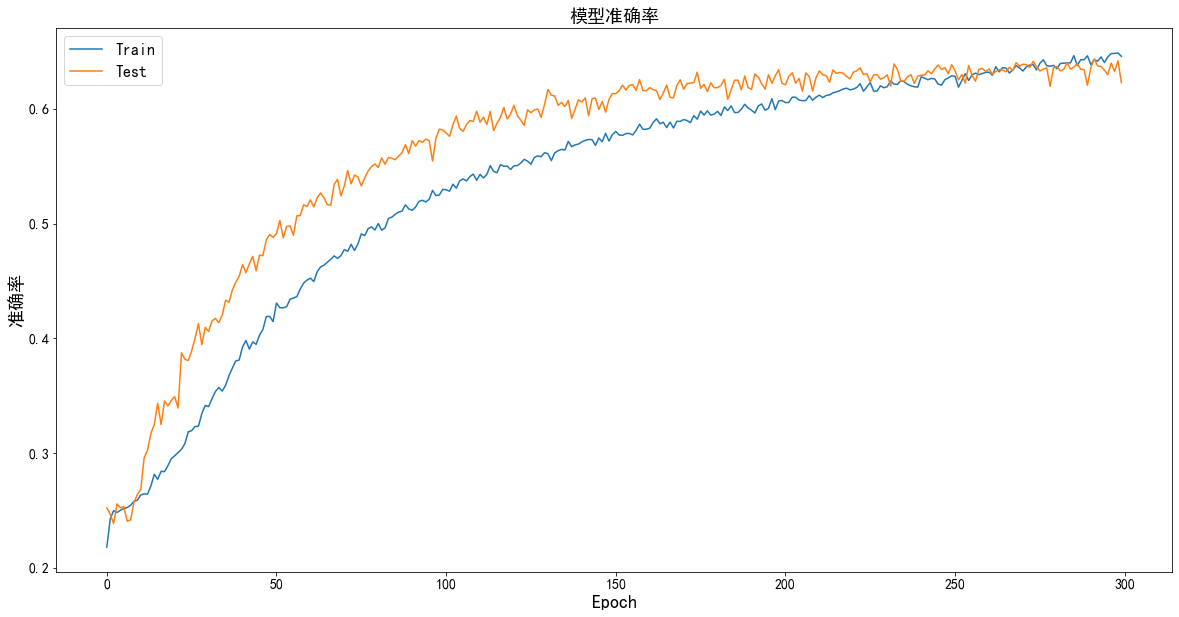

In [13]:
history = pd.read_csv('history.csv', usecols = ['accuracy','loss','val_accuracy','val_loss'])

plt.figure(figsize=(20,10)) 
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('模型准确率', fontsize = 18)
plt.ylabel('准确率', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()
    


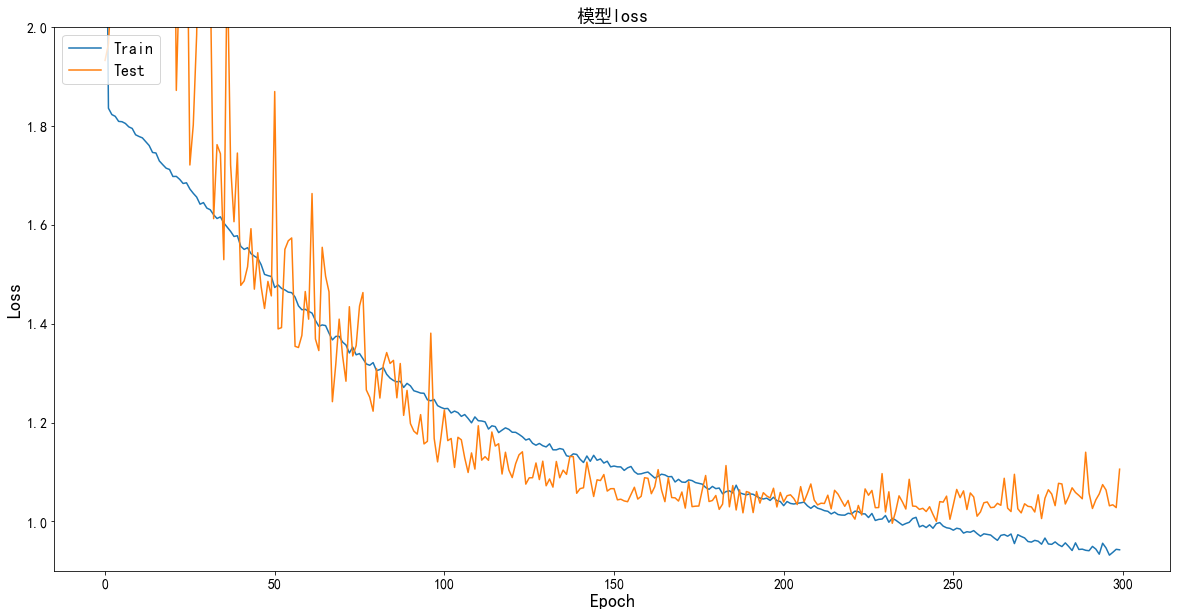

In [14]:
plt.figure(figsize=(20,10)) 
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('模型loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylim(0.9,2)
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [15]:
# 导入预测集
predict_data = []

name = []

for dirname, _, filenames in os.walk(r'.\test'):
    for filename in filenames:
        try:
            image_array = Image.open(os.path.join(dirname, filename))
            image_array = image_array.resize((64,64),Image.ANTIALIAS)
            image_array = np.array(image_array)
            image_array = np.expand_dims(image_array, axis=2)
            predict_data.append(image_array)
            name.append(filename)
        except:
            pass

In [16]:
predict_data = np.array(predict_data)

# 对数据进行标准化
predict_data = np.divide(np.subtract(predict_data,each_pixel_mean), each_pixel_std)

In [17]:
preds = model.predict(np.array(predict_data))

In [18]:
import numpy as np
y_test_pred = np.argmax(preds, axis=1)

In [19]:
final_result_list = []
for i in y_test_pred:
    final_result_list.append(label_dic[i])

In [20]:
final_result_df = pd.DataFrame({'file_name': name,
                                'class': final_result_list},index=name)

In [21]:
final_result_df.to_excel('人物表情分类结果.xlsx')
final_result_df=pd.read_excel('人物表情分类结果.xlsx',index_col=0)
final_result_df.index=name

In [22]:
model.save('model.h5')

In [ ]:
df=pd.read_csv('submission.csv')

In [ ]:
df.index=df['file_name']
df['file_name']=final_result_df['file_name']
df['class']=final_result_df['class']
df.to_csv('submission_final.csv',index=None)